In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os,glob
import math
%matplotlib inline

imagePath = os.path.join('.','data','MISTSET','000')
imageNames = glob.glob(os.path.join(imagePath,'IMG_0095_*.tif'))

# Read raw image DN values
# reads 16 bit tif - this will likely not work for 12 bit images
index = 0
imageRaws = np.ndarray(shape = (960,1280,5))
for names in imageNames:
    img = plt.imread(names)
    imageRaws[:,:,index] = (img - np.min(img))/(np.max(img) - np.min(img)) * 255
    index = index + 1

Height:  960
Width:   1280


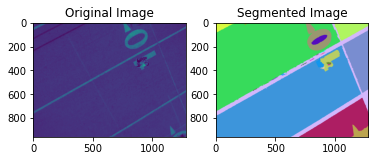

Execution time: 1 minute(s) and 46 seconds


In [2]:
from segment import *

sigma = 0.5
k = 300
min_size = 100

image_cluster, segment_graph = segment(imageRaws, sigma, k, min_size)

In [3]:
# reshape imageRaws for covariance calculation
# reshape_images = reshape_images.transpose(1,0)
reshape_images = imageRaws.transpose(0,1,2).reshape((960*1280,5))

# covariance matrix
M = np.cov(reshape_images, rowvar = False)

In [4]:
eigenvalues, eigenvectors = np.linalg.eig(M)
print(eigenvalues)
print(eigenvectors)

[1829.7967971   641.89498574   58.82947841  180.80739948  243.47016811]
[[-0.24445431 -0.08903725 -0.94911036  0.16236422 -0.07170665]
 [-0.57710179 -0.20581283  0.28841767  0.44563679 -0.58550636]
 [-0.26521316  0.36616179 -0.05958646 -0.75495113 -0.47125977]
 [-0.39288276  0.79245597  0.05026625  0.29496415  0.35794709]
 [-0.61846643 -0.43318879  0.09963699 -0.3436432   0.54938927]]


In [5]:
# choose max 3 eigenvalues
max_eig = np.argpartition(-eigenvalues,2)[:3]

In [6]:
e = np.ndarray(shape = (5,3))
e[:,0] = eigenvectors[:,max_eig[0]]
e[:,1] = eigenvectors[:,max_eig[1]]
e[:,2] = eigenvectors[:,max_eig[2]]

# 3 color component value
color_vector = np.dot(reshape_images,e)

In [7]:
class segmented_image:
    def __init__(self, color_vector, segment_graph):
        self.rep = np.empty(shape=(960*1280,1), dtype=int)
        self.loc = np.empty(shape=(960*1280,1), dtype=int)
        self.col = np.empty(shape=(960*1280,3))
        for i in range(960*1280):
            # representitive, location, color value
            self.rep[i] = segment_graph.elts[i,2]
            self.loc[i] = segment_graph.elts[i,0]
            self.col[i] = color_vector[i,:]
    def ref(self, i):
        return self.rep[i]
    def location(self, i):
        x = i//1280
        y = i%1280
        return np.array([x,y])
    def color(self,i):
        return self.col[i]


In [8]:
segment_image = segmented_image(color_vector, segment_graph)

In [9]:
reps, rep_indices = np.unique(segment_image.rep , return_inverse=True)

In [10]:
clust = [[] for _ in range(reps.size)]
k = 0

for rep in reps:
    for i in range(960*1280):
        if segment_image.rep[i] == rep:
            x = segment_image.location(i)[0]
            y = segment_image.location(i)[1]
            clust[k].append([x,y,segment_image.col[i][0],segment_image.col[i][1],segment_image.col[i][2]])
    k += 1

In [11]:
histo = np.empty(shape = (k,3,10))
bin_edges = np.empty(shape = (k,3,11))

for i in range(k):
    data = np.empty(shape = (len(clust[i]),3))
    for l in range(len(clust[i])):
        data[l,:] = clust[i][l][2:]
    histo[i,0,:], bin_edges[i,0,:] = np.histogram(data[:,0], range=(min(color_vector[:,0]),max(color_vector[:,0])), density=True)
    histo[i,1,:], bin_edges[i,1,:] = np.histogram(data[:,1], range=(min(color_vector[:,1]),max(color_vector[:,1])), density=True)
    histo[i,2,:], bin_edges[i,2,:] = np.histogram(data[:,2], range=(min(color_vector[:,2]),max(color_vector[:,2])), density=True)


In [12]:
distance_matrix = np.empty(shape = (10,10,3))
for x in range(10):
    for y in range(10):
        distance_matrix[x,y,0] = np.abs(x-y)*(bin_edges[0,0,1]-bin_edges[0,0,0])/10
        distance_matrix[x,y,1] = np.abs(x-y)*(bin_edges[0,1,1]-bin_edges[0,1,0])/10
        distance_matrix[x,y,2] = np.abs(x-y)*(bin_edges[0,2,1]-bin_edges[0,2,0])/10

In [13]:
saliency = np.empty(shape=(k,))

for i in range(k):
    for j in range(k):
        saliency[i] = np.sum(np.multiply(np.outer(histo[i,0,:],histo[j,0,:]), distance_matrix[:,:,0]))
        saliency[i] += np.sum(np.multiply(np.outer(histo[i,1,:],histo[j,1,:]), distance_matrix[:,:,1]))
        saliency[i] += np.sum(np.multiply(np.outer(histo[i,2,:],histo[j,2,:]), distance_matrix[:,:,2]))

In [14]:
#normalize
sal_max = np.max(saliency)
sal_min = np.min(saliency)

saliency_norm = (saliency - sal_min)/(sal_max - sal_min)

In [15]:
image_saliency_norm = np.empty(shape = (960,1280))
saliency_cut = np.zeros(shape=(960,1280))

for i in range(len(clust)):
    sal = saliency_norm[i]
    for j in range(len(clust[i])):
        x = clust[i][j][0]
        y = clust[i][j][1]
        image_saliency_norm[x,y] = sal
        if sal == 1:
            saliency_cut[x,y] = 1

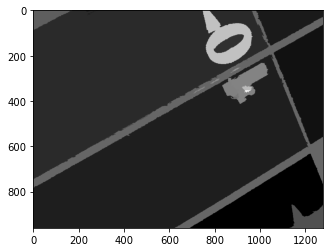

In [16]:
plt.imshow(image_saliency_norm, cmap = 'gray')

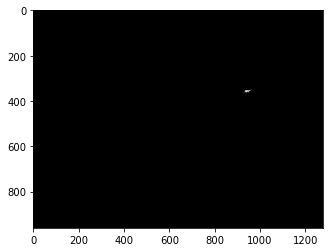

In [17]:
plt.imshow(saliency_cut, cmap = 'gray')